# Emotion Classification with the WASSA-2022 emotion dataset

In this notebook, we will use a state of the art technique from [AdityaPatkar](https://aclanthology.org/2023.wassa-1.46/) to perform emotion classification using the WASSA 2022 emotion dataset. The authors utilize a fine-tuned RoBERTa model and achieved state of the art performance through the usage of complex feature engineering and overfitting techniques. We will attempt to replicate their results using a similar approach.

## Imports and Constants

In [ ]:
import transformers
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from functools import partial

# Constant value due to memory constraints
# Should roughly fit in Batch size/2 GBs of VRAM with our implementation
BATCH_SIZE = 32

## Loading the Dataset

We observe that the dataset is a csv file, however semi-colons are used as a separator. Additionally, the labels need to be mapped to numerical values. We will load the dataset and perform these operations.

In [ ]:
# Load the dataset
train = pd.read_csv('train_ready_for_WS.csv', encoding='utf-8', sep=';')
test = pd.read_csv('test.csv', encoding='utf-8', sep=';')

train.head()

,article_id,essay,emotion
0,67,it is really diheartening to read about these ...,sadness
1,86,the phone lines from the suicide prevention li...,sadness
2,206,"no matter what your heritage, you should be ab...",neutral
3,290,it is frightening to learn about all these sha...,fear
4,342,the eldest generation of russians aren't being...,sadness


In [ ]:
# Obtain emotion mapping from the dataset
emotions = train['emotion'].unique()
emotion_map = {emotion: idx for idx, emotion in enumerate(emotions)}

# Convert map to dataframe
emotion_map_df = pd.DataFrame(emotion_map.items(), columns=['emotion', 'label'])
emotion_map_df

,emotion,label
0,sadness,0
1,neutral,1
2,fear,2
3,anger,3
4,disgust,4
5,surprise,5
6,joy,6


In [ ]:
# Apply the mapping to the datasets
train_encoded = train.copy()
train_encoded['emotion'] = train_encoded['emotion'].map(emotion_map)

test_encoded = test.copy()
test_encoded['emotion'] = test_encoded['emotion'].map(emotion_map)

train_encoded.head()

,article_id,essay,emotion
0,67,it is really diheartening to read about these ...,0
1,86,the phone lines from the suicide prevention li...,0
2,206,"no matter what your heritage, you should be ab...",1
3,290,it is frightening to learn about all these sha...,2
4,342,the eldest generation of russians aren't being...,0


## Exploratory Data Analysis

We will perform some basic exploratory data analysis to understand the dataset better. This will include visualizing the distribution of the labels, and the distribution of the number of words in the text. To prevent data leakage, we will only examine the training set.

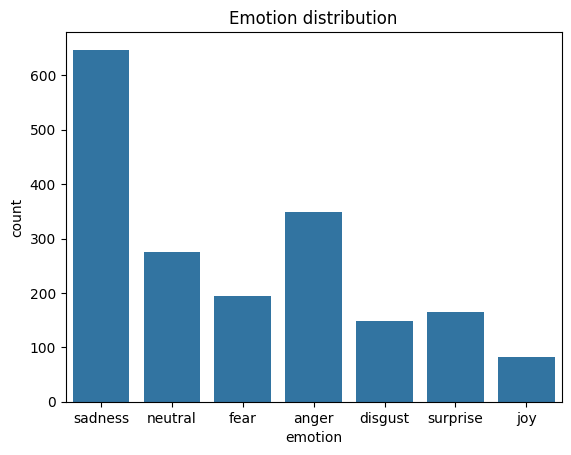

In [ ]:
# Plot the distribution of the emotions, emotion is a categorical variable
sns.countplot(x=train['emotion'])

# Add title
plt.title('Emotion distribution')
plt.show()

In [ ]:
# Print ratio of each emotion
print('Emotion distribution:')
print(train['emotion'].value_counts(normalize=True))

Emotion distribution:
emotion
sadness     0.347849
anger       0.187634
neutral     0.147849
fear        0.104301
surprise    0.088172
disgust     0.080108
joy         0.044086
Name: proportion, dtype: float64


In [ ]:
# Check for NA values
print(train.isna().sum())

article_id    0
essay         0
emotion       0
dtype: int64


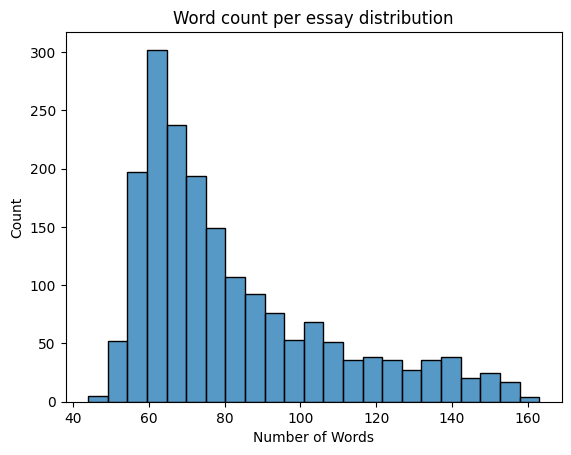

In [ ]:
# Plot the distribution of number of words in an essay
train['Number of Words'] = train['essay'].apply(lambda x: len(x.split()))
sns.histplot(train['Number of Words'])

# Add title
plt.title('Word count per essay distribution')
plt.show()

From this basic investigation, we observe that there is a severe class imbalance in the dataset. Additionally, the size of an essay varies greatly with the average hovering around 60 words. We can easily address this issue using a transformer model which can handle variable length inputs due to its attention mechanism.

## Preprocessing

We are using transformers which require minimal text pre-processing as they are designed to handle raw text. However, we will need to tokenize the text and convert it to a format that the model can understand. We will also need to address the class imbalance in the dataset using class weights. Additionally, we will split the training set into a training and validation set.

In [ ]:
# Compute the class weights and add to the mapping dataframe
# We compute the class weights as w_i = N / (k * n_i)
# where N is the total number of samples, k is the number of classes and n_i is the number of samples in class i

# Compute class counts
class_counts = train['emotion'].value_counts()
class_weights = len(train) / (len(emotions) * class_counts)


# Convert to dataframe
class_weights_df = pd.DataFrame(class_weights)
class_weights_df.reset_index(inplace=True)
class_weights_df.columns = ['emotion', 'count']

# Merge with emotion_map_df using emotion column
emotion_map_df = emotion_map_df.merge(class_weights_df, on='emotion')
emotion_map_df

,emotion,label,count
0,sadness,0,0.410687
1,neutral,1,0.966234
2,fear,2,1.369661
3,anger,3,0.761359
4,disgust,4,1.783317
5,surprise,5,1.620209
6,joy,6,3.240418


In [ ]:
for idx, row in emotion_map_df.iterrows():
    train_encoded.loc[train_encoded['emotion'] == row['label'], 'class_weight'] = row['count']
    test_encoded.loc[test_encoded['emotion'] == row['label'], 'class_weight'] = row['count']

train_encoded.head()

,article_id,essay,emotion,class_weight
0,67,it is really diheartening to read about these ...,0,0.410687
1,86,the phone lines from the suicide prevention li...,0,0.410687
2,206,"no matter what your heritage, you should be ab...",1,0.966234
3,290,it is frightening to learn about all these sha...,2,1.369661
4,342,the eldest generation of russians aren't being...,0,0.410687


In [ ]:
# Split the dataset into training and validation
train_df, val_df = train_test_split(train_encoded, test_size=0.3)

In [ ]:
# Create pytorch dataset
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        # Get max length from tokenizer
        self.max_length = tokenizer.model_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        essay = self.data.iloc[idx]['essay']
        label = self.data.iloc[idx]['emotion']
        weight = self.data.iloc[idx]['class_weight']

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'essay': essay,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'label': torch.tensor(label, dtype=torch.long),
            'weight': torch.tensor(weight, dtype=torch.float)
        }

In [ ]:
def emotion_collate(batch, tokenizer):

    input_ids = [item['input_ids'].squeeze(0) for item in batch]  # List of tensors
    attention_mask = [item['attention_mask'].squeeze(0) for item in batch]  # List of tensors
    label = torch.stack([item['label'] for item in batch])
    weight = torch.stack([item['weight'] for item in batch])

    # Pad the input_ids and attention_mask
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': label,
        'weight': weight
    }

In [ ]:
# Create Dataloader which is used to iterate over the dataset
def create_dataloader(data, tokenizer, shuffle, batch_size):
    dataset = EmotionDataset(data, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=partial(emotion_collate, tokenizer=tokenizer))

In [ ]:
# Obtain roberta tokenizer model
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_loader = create_dataloader(train_df, tokenizer, True, BATCH_SIZE)
val_loader = create_dataloader(val_df, tokenizer, True, BATCH_SIZE)
test_loader = create_dataloader(test_encoded, tokenizer, False, BATCH_SIZE)

# Combine train and valdf for final training
final_train_df = pd.concat([train_df, val_df])
train_val_loader = create_dataloader(final_train_df, tokenizer, True, BATCH_SIZE)

## Model Creation

Creation of classes required for the model which take hyperparameters as input. Note that RoBERTa is case sensitive which is why we did not convert the text to lowercase during preprocessing.

In [ ]:
def process_batch(model, device, batch):
    """
    Process a batch by using the input_ids and attention_mask
    Returns the loss and the number of correct predictions
    """
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # Get number of correct predictions
    preds = torch.argmax(outputs.logits, dim=1)
    correct_predictions = (preds == labels).float()

    # Get the loss taking class weights into account
    loss = outputs.loss * batch['weight'].to(device)
    loss = loss.mean()

    return loss, correct_predictions


In [ ]:
def train_model(model, optimizer, device, dataset):
    """
    Train the model
    """
    # Set the model to train mode
    model.train()

    # Initialize total loss to store accumulated loss during training
    total_loss = 0

    # Iterate over batches in the dataset
    for batch in dataset:

        # Clear gradients from previous iteration
        optimizer.zero_grad()

        # Process the current batch and get the loss
        loss, _ = process_batch(model, device, batch)

        # Add the current batch's loss to the total loss
        total_loss += loss.item()

        # Perform backward pass to calculate gradients
        loss.backward()

        # Update model parameters based on the calculated gradients
        optimizer.step()

    # Calculate and return average loss over the entire dataset
    return total_loss / len(dataset)

In [ ]:
def evaluate_model(model, device, dataset):
    """
    Evaluate the model
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataset:
            loss, _ = process_batch(model, device, batch)
            total_loss += loss.item()
    return total_loss / len(dataset)

In [ ]:
def train_configuration(model, optimizer, device, train_loader, val_loader, epochs):
    """
    Train the model for a number of epochs and return the train and validation losses
    """
    train_losses = []
    val_losses = []

    for _ in tqdm(range(epochs)):

        train_loss = train_model(model, optimizer, device, train_loader)
        train_losses.append(train_loss)

        if val_loader is None:
            continue

        val_loss = evaluate_model(model, device, val_loader)
        val_losses.append(val_loss)

        # Early stopping
        if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
            break

    return train_losses, val_losses

In [ ]:
def create_model(model_name, device):
    """
    Create the model
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(emotions))
    model.to(device)
    return model

In [ ]:
def create_optimizer(model, base_lr, weight_decay):
    """
    Create the optimizer
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    return optimizer

## Model Training

Training loop with hyperparameter tuning

In [ ]:
hyperparameters = {
     "learning_rate": [1e-5, 2e-5, 3e-5],
     "epochs": [25], # Early stopping is used so this is a maximum
     "decay": [0.1, 0.2, 0.5] # Used in reference paper
}

In [ ]:
# Create a dataframe to store the hyperparameters and the corresponding losses
# Use the hyper-parameter keys as columns
model_configuration_df = pd.DataFrame(columns=list(hyperparameters.keys()) + ['train_losses', 'val_losses'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate over the hyperparameters combinations and train the model
# The combination is be a dictionary with the same keys as the hyperparameters dictionary
for combination in tqdm(list(itertools.product(*hyperparameters.values())), desc='Hyperparameter combinations'):

    # Create a dictionary with the hyperparameters
    params = {key: value for key, value in zip(hyperparameters.keys(), combination)}
    print(params)

    # Create the model and the optimizer
    model = create_model('roberta-base', device)
    optimizer = create_optimizer(model, base_lr=params['learning_rate'], weight_decay=params['decay'])

    # Train the model and obtain the train and validation losses
    train_losses, val_losses = train_configuration(model, optimizer, device, train_loader, val_loader, epochs=params['epochs'])

    # Add the hyperparameters and the corresponding losses to the dataframe
    model_configuration_df.loc[len(model_configuration_df)] = list(params.values()) + [train_losses, val_losses]

    # Modify the epoch value to the actual number of epochs
    model_configuration_df.loc[len(model_configuration_df) - 1, 'epochs'] = len(train_losses)

Hyperparameter combinations:   0%|          | 0/9 [00:00<?, ?it/s]

{'learning_rate': 1e-05, 'epochs': 25, 'decay': 0.1}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 1e-05, 'epochs': 25, 'decay': 0.2}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 1e-05, 'epochs': 25, 'decay': 0.5}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 2e-05, 'epochs': 25, 'decay': 0.1}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 2e-05, 'epochs': 25, 'decay': 0.2}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 2e-05, 'epochs': 25, 'decay': 0.5}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 3e-05, 'epochs': 25, 'decay': 0.1}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 3e-05, 'epochs': 25, 'decay': 0.2}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

{'learning_rate': 3e-05, 'epochs': 25, 'decay': 0.5}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
def plot_losses(train_losses, val_losses):

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.legend()

    # Label the axes and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')

    # Make x axis discrete
    plt.xticks(range(len(train_losses)))
    plt.show()

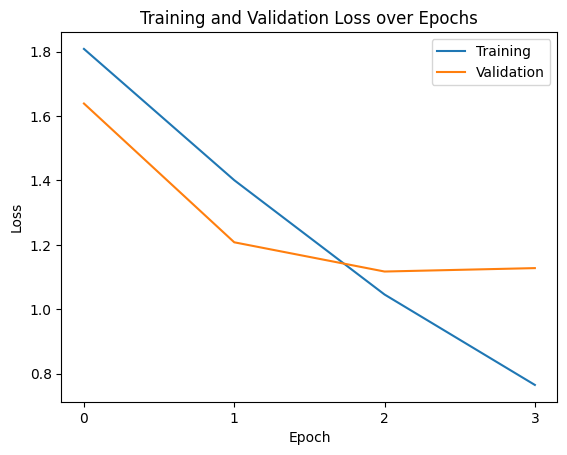

In [ ]:
# Create a new column 'last_val_loss' that contains the last validation loss for each row
model_configuration_df['last_val_loss'] = model_configuration_df['val_losses'].apply(lambda x: x[-1])

# Sort the DataFrame by the 'last_val_loss' column
sorted_df = model_configuration_df.sort_values(by='last_val_loss', ascending=True)
best_configuration = sorted_df.iloc[0]

# Plot the losses for the best configuration
plot_losses(best_configuration['train_losses'], best_configuration['val_losses'])

# Save sorted_df to a csv file
sorted_df.to_csv('sorted_df.csv', index=False)

## Model Evaluation

Macro F1 score, Micro F1 score, precision, recall, confusion matrix

In [ ]:
# Train the model with the best hyperparameters
best_model = create_model('roberta-base', device)
optimizer = create_optimizer(best_model, base_lr=best_configuration['learning_rate'], weight_decay=best_configuration['decay'])

# Train the model again since we cannot store the model from the previous training due to the large size
train_losses, val_losses = train_configuration(best_model, optimizer, device, train_val_loader, None, epochs=best_configuration['epochs'])

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def metric_evaluation(model, device, test_loader):
    """
    Report the metrics for the model
    """
    model.eval()
    model.to(device)

    true_labels = []
    predictions = []

    # Collect the predictions
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)


            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    # Calculate evaluation metrics
    # Calculate F1-score, which is a harmonic mean of precision and recall, for each class
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    # This also calculates the F1-score, but it takes the weighted mean of the F1-score across all classes
    micro_f1 = f1_score(true_labels, predictions, average='micro')

    # Calculate precision, which is the proportion of predicted positives that are actually positive
    precision = precision_score(true_labels, predictions, average='macro')

    # Calculate recall, which is the proportion of actual positives that are predicted positive
    recall = recall_score(true_labels, predictions, average='macro')

    # Make confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate accuracy, which is the overall proportion of predictions that are correct
    accuracy = accuracy_score(true_labels, predictions)

    print(f'Macro F1: {macro_f1}')
    print(f'Micro F1: {micro_f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')

    # display the confusion matrix, use seaborn heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Macro F1: 0.5874168149999848
Micro F1: 0.6703703703703704
Precision: 0.599729044734425
Recall: 0.5989810767867662
Accuracy: 0.6703703703703704


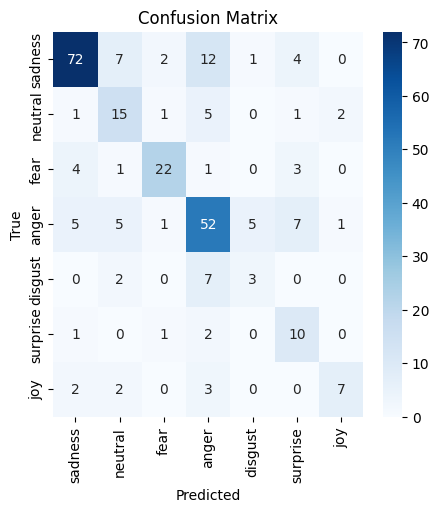

In [ ]:
# What is this one?
metric_evaluation(best_model, device, test_loader)

We observe that the model performs well and outperforms the baseline of 35% accuracy from the most frequent class. Continue here later